<a href="https://colab.research.google.com/github/tiensu/DATA_SCIENCE_PJ/blob/master/Predict_Employee_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [26]:
# Load data
data = pd.read_csv('./drive/My Drive/MACHINE_LEARNING_CODE/DATA_SET/HR_comma_sep.csv', index_col=None)
#data.columns.values.tolist()
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Check data
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Departments              0
salary                   0
dtype: int64

In [28]:
# Rename column name
data = data.rename(columns = {'satisfaction_level': 'satisfaction',
                             'last_evaluation': 'evaluation',
                             'number_project': 'projectCount',
                             'average_montly_hours': 'averageMonthlyHours',
                             'time_spend_company': 'yearsAtCompany',
                             'Work_accident': 'workAccident',
                             'promotion_last_5years': 'promotion',
                             'Departments ': 'department',
                             'left': 'turnover'})
data.head()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [29]:
# Reorder columns
turnOver = data.turnover
data.drop(['turnover'], axis=1, inplace=True)
data.insert(0, 'turnover', turnOver)
data.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


In [7]:
"""Analyzing data"""
# There is about 15.000 employee with 10 features
data.shape

(14999, 10)

In [8]:
# Resign rate ~24%
turnoverRate = data.turnover.value_counts() / data.shape[0]
turnoverRate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [9]:
# Average of satisfaction ~61%
data.satisfaction.mean()

0.6128335222348156

In [10]:
# Min of satisfaction is 9%
data.satisfaction.min()

0.09

In [11]:
# Max of satisfaction 100%
data.satisfaction.max()

1.0

In [12]:
# Quit people have satisfaction is lower than stay people
data.groupby('turnover').satisfaction.mean()

turnover
0    0.666810
1    0.440098
Name: satisfaction, dtype: float64

Text(0.5,1,'Employee Year At Company Distribution')

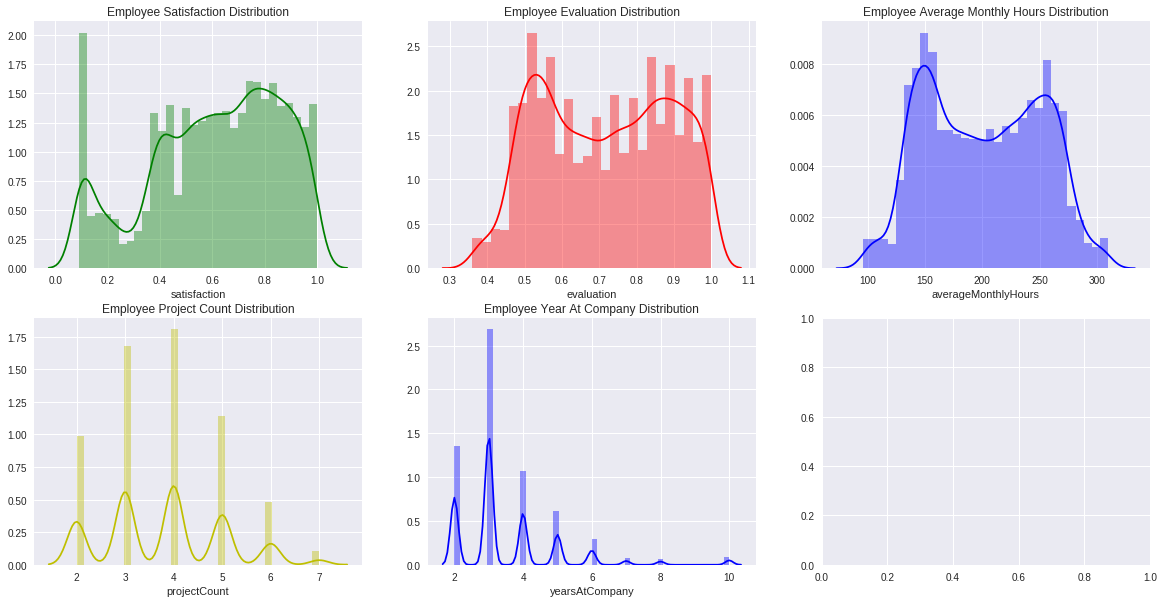

In [15]:
# Distribution of some important features
f, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
sns.distplot(data.satisfaction, color='g', ax=axes[0][0]).set_title('Employee Satisfaction Distribution')
sns.distplot(data.evaluation, color='r', ax=axes[0][1]).set_title('Employee Evaluation Distribution')
sns.distplot(data.averageMonthlyHours, color='b', ax=axes[0][2]).set_title('Employee Average Monthly Hours Distribution')
sns.distplot(data.projectCount, color='y', ax=axes[1][0]).set_title('Employee Project Count Distribution')
sns.distplot(data.yearsAtCompany, color='b', ax=axes[1][1]).set_title('Employee Year At Company Distribution')


'\nPositively correlated:\n  projectCount vs evaluation: 0.349333\n  projectCount vs averageMonthlyHours:  0.417211\n  averageMonthlyHours vs evaluation: 0.339742\n  -> những nhân viên dành nhiều thời gian làm việc tại công ty hơn và tham gia nhiều project hơn sẽ được đánh giá cao hơn.\nNegatively correlated:\n  satisfaction vs turnover:  -0.388375\n  -> càng ít thoả mãn thì khả năng rời đi càng cao.\n'

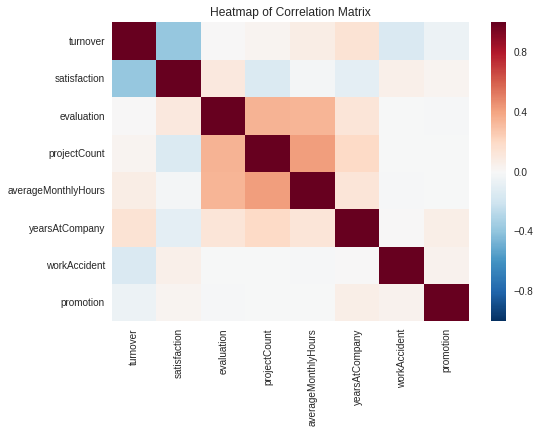

In [14]:
# Corr matrix
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values).set_title('Heatmap of Correlation Matrix')
corr

"""
Positively correlated:
  projectCount vs evaluation: 0.349333
  projectCount vs averageMonthlyHours:  0.417211
  averageMonthlyHours vs evaluation: 0.339742
  -> những nhân viên dành nhiều thời gian làm việc tại công ty hơn và tham gia nhiều project hơn sẽ được đánh giá cao hơn.
Negatively correlated:
  satisfaction vs turnover:  -0.388375
  -> càng ít thoả mãn thì khả năng rời đi càng cao.
"""

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Employee Salary Turnover Distribution')

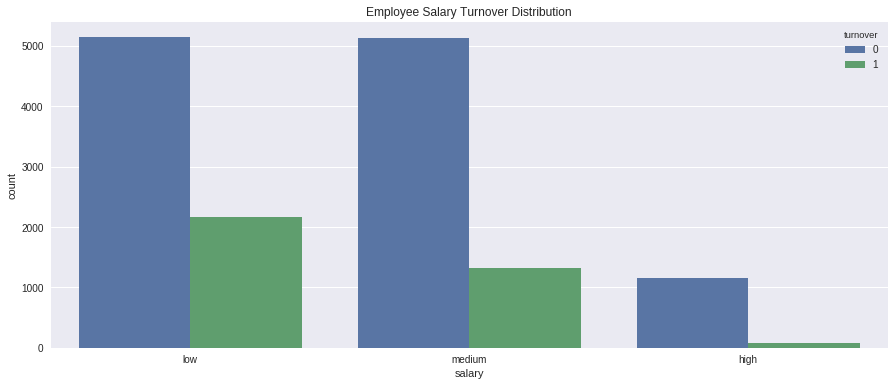

In [16]:
# Turnover vs Salary
plt.figure(figsize=(15, 6))
sns.countplot(x='salary', hue='turnover', data=data).set_title('Employee Salary Turnover Distribution') 

# Phần lớn nhân viên ra đi có lương thấp hoặc trung bình
# Những nhân viên có lương cao ít ra đi

# Suy ngẫm: Vẫn có những nhân viên lương cao ra đi, lý do vì đâu?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

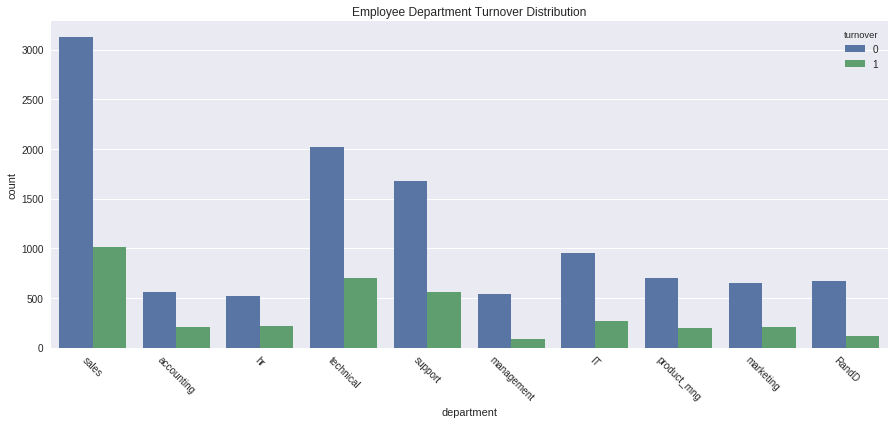

In [17]:
# Turnover vs Department
plt.figure(figsize=(15, 6))
sns.countplot(x='department',hue='turnover', data=data).set_title('Employee Department Turnover Distribution');
plt.xticks(rotation=-45)
# Các bộ phận có người nghỉ nhiều nhất là sales, technical và support.
# Có thể thấy rằng sales và technical là các bộ phận thường xuyên chịu áp lực lớn về doanh số cũng như deadline, còn support thì chịu cảnh làm dâu trăm họ cũng chẳng sung sướng gì.
# Các sếp (bên management) là ít chuyển việc nhất.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Employee Project Count Turnover Distribution')

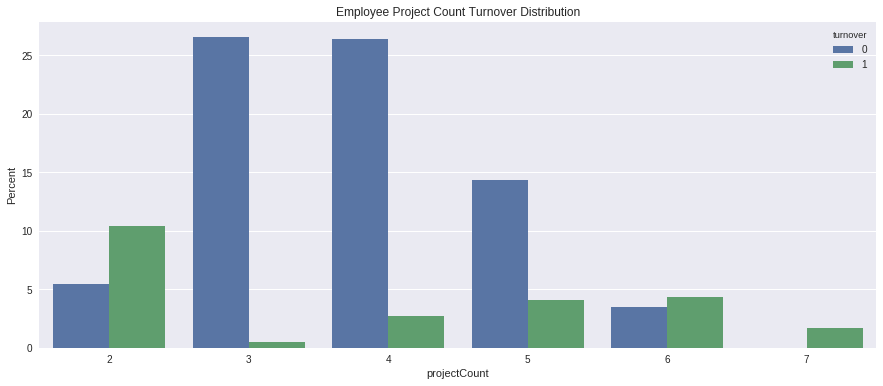

In [18]:
# Turnover vs Project Count
#sns.countplot(x='projectCount', hue='turnover', data=data).set_title('Employee Project Count Turnover Distribution')
plt.figure(figsize=(15, 6))
ax = sns.barplot(x="projectCount", y="projectCount", hue="turnover", data=data, estimator=lambda x: len(x) / len(data) * 100)
ax.set(ylabel="Percent")
ax.set_title('Employee Project Count Turnover Distribution')

# Hơn nửa số nhân viên ra đi khi đã làm 2, 6 và 7 projects
# Phần lớn số người không rời công ty khi làm 3, 4, 5 project
# Số làm 7 projects ra đi sạch sẽ
# Có dấu hiệu tăng của tỉ lệ ra đi khi càng làm nhiều project

Text(0.5,1,'Employee Evaluation Distribution - Turnover V.S. No Turnover')

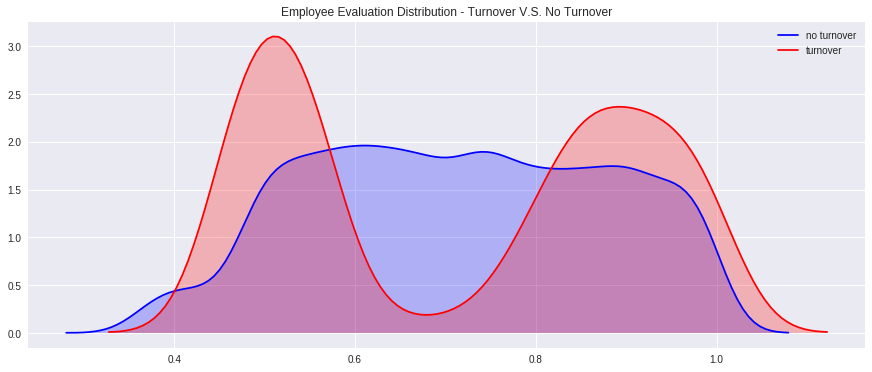

In [19]:
# Evaluation vs Turnover
# sns.countplot(x='evaluation',hue='turnover', data=data).set_title('Employee Department Turnover Distribution');
fig = plt.figure(figsize=(15,6))
sns.kdeplot(data[data['turnover'] == 0].evaluation , color='b',shade=True,label='no turnover')
sns.kdeplot(data[data['turnover'] == 1].evaluation , color='r',shade=True, label='turnover')
plt.title('Employee Evaluation Distribution - Turnover V.S. No Turnover')

# Nhân viên được đánh giá thấp quá cũng sẽ ra đi
# Nhân viên được đánh giá cao quá cũng sẽ ra đi
# Nhân viên trung bình và khá, tức mức Evaluation từ 0.6-0.8 là những người ở lại với công ty. Có thể hiểu là với mức đánh giá đó, họ luôn còn mục tiêu để mà cố gắng

Text(0.5,1,'Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

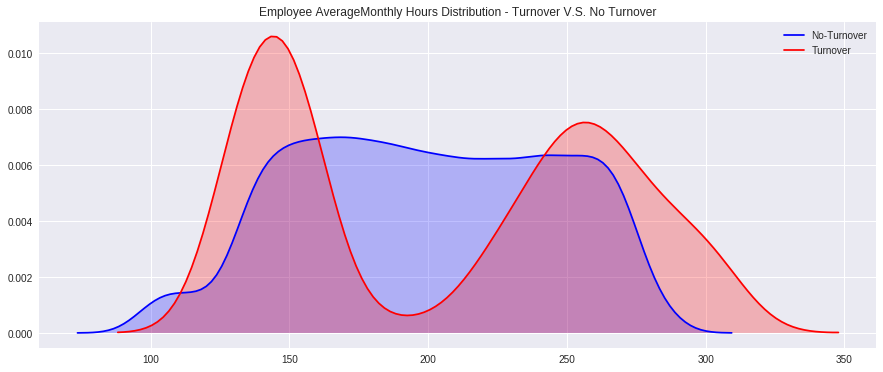

In [20]:
# Turnover and averageMonthlyHours
fig = plt.figure(figsize=(15,6))
sns.kdeplot(data[data['turnover'] == 0].averageMonthlyHours, color='b', shade=True, label='No-Turnover')
sns.kdeplot(data[data['turnover'] == 1].averageMonthlyHours, color='r', shade=True, label='Turnover')
plt.title('Employee AverageMonthly Hours Distribution - Turnover V.S. No Turnover')

# Nhân viên làm việc ít hơn 150h/tháng sẽ nghỉ
# Nhân viên làm việc nhiều hơn 250h/tháng sẽ nghỉ

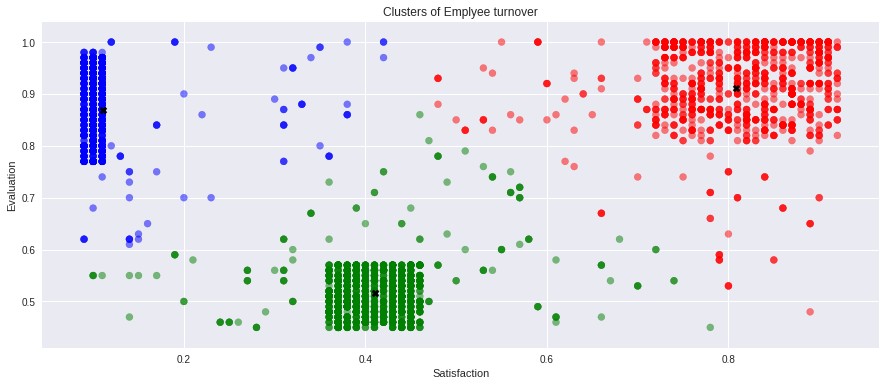

In [44]:
# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
turnover_emp = data[data.turnover==1][['satisfaction','evaluation']]
kmeans.fit(turnover_emp)
kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]
plt.figure(figsize=(15, 6))
plt.scatter(x='satisfaction', y='evaluation',data=data[data.turnover==1], c=kmeans_colors, alpha=0.5)
plt.xlabel('Satisfaction')
plt.ylabel('Evaluation')
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], c='black', marker='X')
plt.title('Clusters of Emplyee turnover')
plt.show()

In [0]:
# Conclustion
# Nhân viên làm ít việc quá sẽ nghỉ việc (ít hơn 150h/tháng hay 6h/ngày)
# Nhân viên làm nhiều việc quá sẽ nghỉ việc (nhiều hơn 250h/tháng hay 10h/ngày)
# Nhân viên có đánh giá quá thấp hay quá cao đều nghỉ.
# Lương thấp và trung bình cũng dễ dẫn tới nghỉ.
# Nhân viên tại các project thứ 2, 6, 7 có nguy cơ cao là nghỉ.
# Nhóm top-class khi làm việc từ 5 năm trở lên sẽ có xu hướng ra đi.

In [0]:
# Build model

# Create label encoder
lbEnc = preprocessing.LabelEncoder()
data.salary = lbEnc.fit_transform(data.salary)
data.department = lbEnc.fit_transform(data.department)

In [0]:
# Split data
X = data.drop(['turnover'], axis=1)
y= data.turnover

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Create/train Gradient Bossting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Predict
y_pred = gb.predict(X_test)

In [60]:
# Evaluation
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))

Accuracy: 0.9733333333333334
Precision: 0.9616519174041298
Recall: 0.9235127478753541
